# Installation


In [1]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/challenge/Car-Damage-Detection")

In [ ]:
!pip install -r requirements.txt

In [8]:
!pip install pyyaml>=5.1

In [ ]:
!pip install detectron2==0.2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

# Import Libraries

In [4]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version


1.5.1+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [5]:
assert torch.__version__.startswith("1.5")

In [6]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import skimage.io as io
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Set base params
plt.rcParams["figure.figsize"] = [16,9] 

# Register Car Damage Dataset

In [7]:
dataset_dir = "/content/drive/My Drive/Colab Notebooks/challenge/Car-Damage-Detection/COCO_dataset/"
img_dir = "img/"
train_dir = "train/"
val_dir = "val/"

In [8]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("car_mul_dataset_train", {}, os.path.join(dataset_dir,train_dir,"COCO_mul_train_annos.json"), os.path.join(dataset_dir,img_dir))
register_coco_instances("car_mul_dataset_val", {}, os.path.join(dataset_dir,val_dir,"COCO_mul_val_annos.json"), os.path.join(dataset_dir,img_dir))

In [9]:
dataset_dicts = DatasetCatalog.get("car_mul_dataset_train")
metadata_dicts = MetadataCatalog.get("car_mul_dataset_train")

[07/15 09:50:56 d2.data.datasets.coco]: Loading /content/drive/My Drive/Colab Notebooks/challenge/Car-Damage-Detection/COCO_dataset/train/COCO_mul_train_annos.json takes 2.06 seconds.
[07/15 09:50:56 d2.data.datasets.coco]: Loaded 59 images in COCO format from /content/drive/My Drive/Colab Notebooks/challenge/Car-Damage-Detection/COCO_dataset/train/COCO_mul_train_annos.json


# Train

In [10]:
#Implementing my own Trainer Module here to use the COCO validation evaluation during training
class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_mul_eval", exist_ok=True)
        output_folder = "coco_mul_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [11]:
cfg = get_cfg()
cfg.OUTPUT_DIR = "./mul_output"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("car_mul_dataset_train",)
cfg.DATASETS.TEST = ("car_mul_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.WARMUP_ITERS = 800
cfg.SOLVER.MAX_ITER = 1000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (600, 1000)
cfg.SOLVER.GAMMA = 0.05
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this  dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  # only has five classes (headlamp,hood,rear_bumper,front_bumper_door)
cfg.TEST.EVAL_PERIOD = 400

# Clear any logs from previous runs
#TODO add timestamp to logs
!rm -rf cfg.OUTPUT_DIR
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[07/15 09:53:49 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:16, 10.8MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to

[07/15 09:54:13 d2.engine.train_loop]: Starting training from iteration 0
[07/15 09:54:59 d2.utils.events]:  eta: 0:36:26  iter: 19  total_loss: 2.835  loss_cls: 1.817  loss_box_reg: 0.212  loss_mask: 0.691  loss_rpn_cls: 0.108  loss_rpn_loc: 0.027  time: 2.2078  data_time: 0.1101  lr: 0.000025  max_mem: 3239M
[07/15 09:55:42 d2.utils.events]:  eta: 0:35:17  iter: 39  total_loss: 2.191  loss_cls: 1.206  loss_box_reg: 0.241  loss_mask: 0.687  loss_rpn_cls: 0.092  loss_rpn_loc: 0.026  time: 2.1854  data_time: 0.0147  lr: 0.000050  max_mem: 3239M
[07/15 09:56:26 d2.utils.events]:  eta: 0:34:33  iter: 59  total_loss: 1.503  loss_cls: 0.486  loss_box_reg: 0.212  loss_mask: 0.676  loss_rpn_cls: 0.070  loss_rpn_loc: 0.021  time: 2.1899  data_time: 0.0142  lr: 0.000075  max_mem: 3248M
[07/15 09:57:11 d2.utils.events]:  eta: 0:34:02  iter: 79  total_loss: 1.387  loss_cls: 0.383  loss_box_reg: 0.270  loss_mask: 0.657  loss_rpn_cls: 0.052  loss_rpn_loc: 0.024  time: 2.2017  data_time: 0.0146  lr:

## Model Metrics and Hyper Parameters Visualization

In [12]:
# Look at training curves in tensorboard:
%reload_ext tensorboard
%tensorboard --logdir mul_output

<IPython.core.display.Javascript object>

# Model Evaluation

In [13]:
mul_evaluator = COCOEvaluator("car_mul_dataset_val", cfg, False, output_dir="./mul_output/")
mul_val_loader = build_detection_test_loader(cfg, "car_mul_dataset_val")
print(inference_on_dataset(trainer.model, mul_val_loader, mul_evaluator))

[07/15 10:40:22 d2.data.datasets.coco]: Loaded 11 images in COCO format from /content/drive/My Drive/Colab Notebooks/challenge/Car-Damage-Detection/COCO_dataset/val/COCO_mul_val_annos.json
[07/15 10:40:22 d2.data.common]: Serializing 11 elements to byte tensors and concatenating them all ...
[07/15 10:40:22 d2.data.common]: Serialized dataset takes 0.01 MiB
[07/15 10:40:22 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/15 10:40:22 d2.evaluation.evaluator]: Start inference on 11 images
[07/15 10:40:26 d2.evaluation.evaluator]: Inference done 11/11. 0.2742 s / img. ETA=0:00:00
[07/15 10:40:26 d2.evaluation.evaluator]: Total inference time: 0:00:02.037156 (0.339526 s / img per device, on 1 devices)
[07/15 10:40:26 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:01 (0.274197 s / img per device, on 1 devices)
[07/15 10:40:26 d2.evaluation.coco_evaluation]: Preparing resul

# Inference

In [14]:
cfg.MODEL.WEIGHTS = os.path.join('./mul_output', "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold for this model
cfg.DATASETS.TEST = ("car_mul_dataset_val", )
mul_predictor = DefaultPredictor(cfg)

In [15]:
val_dataset_dicts = DatasetCatalog.get("car_mul_dataset_val")
val_metadata_dicts = MetadataCatalog.get("car_mul_dataset_val")

[07/15 10:40:41 d2.data.datasets.coco]: Loaded 11 images in COCO format from /content/drive/My Drive/Colab Notebooks/challenge/Car-Damage-Detection/COCO_dataset/val/COCO_mul_val_annos.json


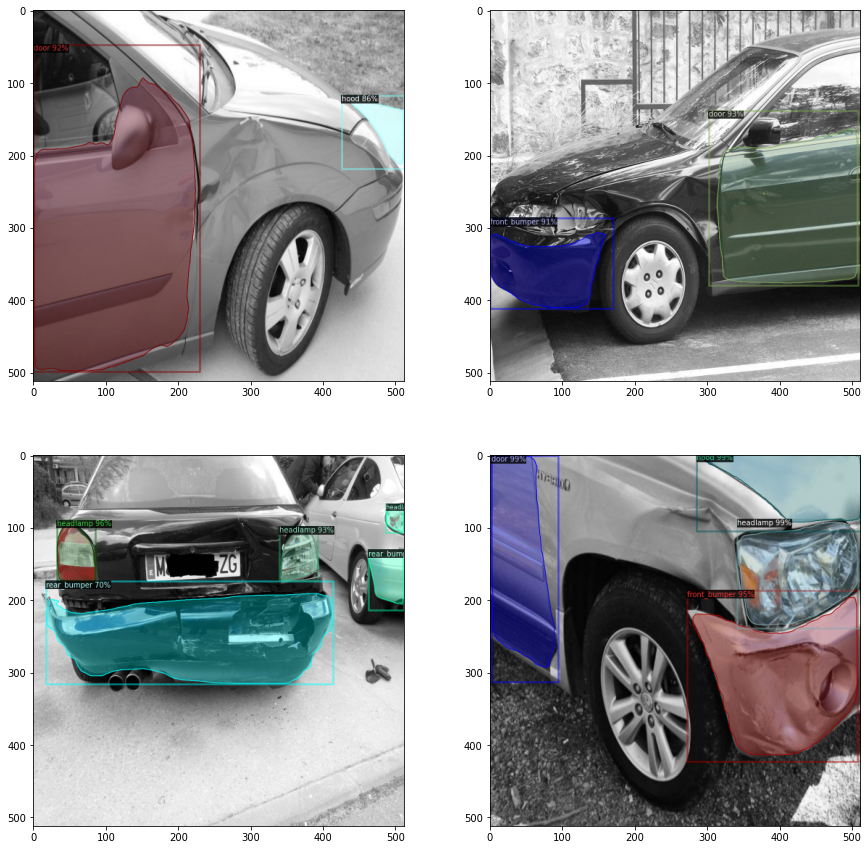

In [20]:
fig, ax = plt.subplots(2, 2,figsize=(15,15))
indices=[ax[0][0],ax[1][0],ax[0][1],ax[1][1] ]
i=-1
for d in random.sample(val_dataset_dicts, 4):
    i=i+1    
    im = io.imread(d["file_name"])
    outputs = mul_predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata_dicts, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    indices[i].imshow(out.get_image()[:, :, ::-1])